# Sentiment Analysis Using Machine Learning Classifiers as well as using Recurrent Neural Network (RNN)

# Importing libraries <a id="1"></a>

In [1]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Loading Dataset <a id="2"></a>

In [2]:
# Construct a tf.data.Dataset
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

In [3]:
data = data.sample(frac=1)
data = data[:200000]

# Data Visualization <a id="3"></a>

Dataset details
target: the polarity of the tweet (0 = negative, 4 = positive)

* date : the date of the tweet (Sat May 16 23:58:44 PDT 2009)
* polarity : the polarity of the tweet (0 = negative 4 = positive)
* user : the user that tweeted (TerraScene)
* text : the text of the tweet (i'm 10x cooler than all of you)

In [4]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 6)


In [5]:
data.head(10)

,polarity,id,date,query,user,text
33390,0,1564496119,Mon Apr 20 03:46:02 PDT 2009,NO_QUERY,cherirobyn,"is not a happy chappy, hate having to make rea..."
1090263,4,1969782850,Sat May 30 01:12:33 PDT 2009,NO_QUERY,rjakesdub,http://bit.ly/LIzYg .. used to play this usin...
873928,4,1679838968,Sat May 02 10:17:55 PDT 2009,NO_QUERY,PaulDuxbury,@PaulaBrett very profound thought Lady Paula
842444,4,1563679673,Sun Apr 19 23:47:48 PDT 2009,NO_QUERY,Stelartron,#TFARP -cycle. Been a rather long solar cycle ...
1382833,4,2052504970,Sat Jun 06 00:57:49 PDT 2009,NO_QUERY,ChristineHitt,@jkhwang he gives u a thumbs up and says 'what...
595741,0,2218844551,Wed Jun 17 23:15:36 PDT 2009,NO_QUERY,apeezy88,Up late... Have to work early
1104884,4,1971219487,Sat May 30 06:32:45 PDT 2009,NO_QUERY,lbruno,@billyp will do. I have a very long list of pe...
1110082,4,1972001791,Sat May 30 08:21:13 PDT 2009,NO_QUERY,jennifercross88,@JME_JME1 aww thank you! i think im doing this...
309476,0,2000914023,Mon Jun 01 23:18:21 PDT 2009,NO_QUERY,ShionK,@JEFFHARDYBRAND sleep driving does suck...MAJO...
262667,0,1986285347,Sun May 31 18:36:48 PDT 2009,NO_QUERY,knoxzee,always: NETWORK TIMEOUT


In [6]:
data['polarity'].unique()

array([0, 4])

In [7]:
# Replacing the value 4 -->1 for ease of understanding.
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
33390,0,1564496119,Mon Apr 20 03:46:02 PDT 2009,NO_QUERY,cherirobyn,"is not a happy chappy, hate having to make rea..."
1090263,1,1969782850,Sat May 30 01:12:33 PDT 2009,NO_QUERY,rjakesdub,http://bit.ly/LIzYg .. used to play this usin...
873928,1,1679838968,Sat May 02 10:17:55 PDT 2009,NO_QUERY,PaulDuxbury,@PaulaBrett very profound thought Lady Paula
842444,1,1563679673,Sun Apr 19 23:47:48 PDT 2009,NO_QUERY,Stelartron,#TFARP -cycle. Been a rather long solar cycle ...
1382833,1,2052504970,Sat Jun 06 00:57:49 PDT 2009,NO_QUERY,ChristineHitt,@jkhwang he gives u a thumbs up and says 'what...


In [8]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.499425,1.999188e+09
std,0.500001,1.930252e+08
min,0.000000,1.467812e+09
25%,0.000000,1.957063e+09
50%,0.000000,2.002267e+09
75%,1.000000,2.176988e+09
max,1.000000,2.329205e+09


In [9]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         200000
No. of positve tagged sentences is:  99885
No. of negative tagged sentences is: 100115


In [10]:
# get a word count per of text
def word_count(words):
    return len(words.split())

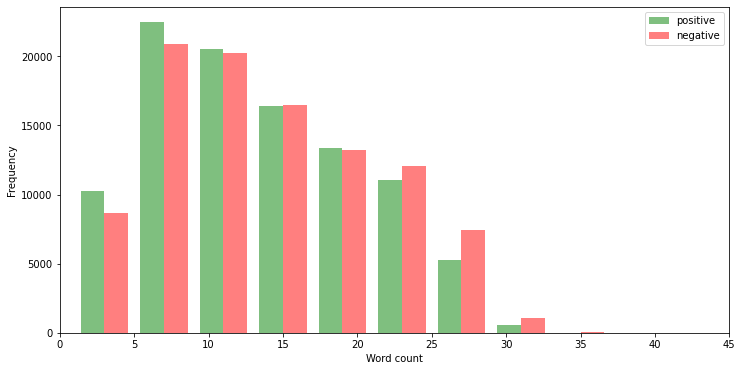

In [11]:
# plot word count distribution for both positive and negative 

data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity == 1]
n = data['word count'][data.polarity == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [12]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('the', 64820),
 ('and', 37233),
 ('you', 29826),
 ('for', 26985),
 ('have', 17937),
 ('that', 16116),
 ("i'm", 15791),
 ('but', 15713),
 ('just', 15550),
 ('with', 14204),
 ('was', 12885),
 ('not', 12747),
 ('this', 11142),
 ('get', 10222),
 ('good', 9685),
 ('like', 9463),
 ('are', 9371),
 ('all', 9153),
 ('out', 8643),
 ('your', 8165)]

# Data Preprocessing <a id="4"></a>

<AxesSubplot:xlabel='polarity', ylabel='count'>

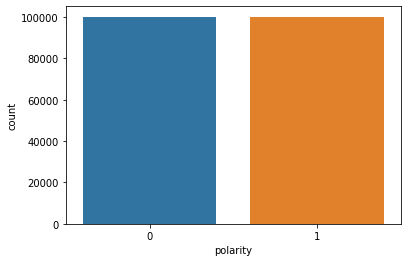

In [13]:
%matplotlib inline
sns.countplot(data['polarity'])

In [14]:
# Removing the unnecessary columns.
data.drop(['date','query','user','word count'], axis=1, inplace=True)

In [15]:
data.drop('id', axis=1, inplace=True)

In [16]:
data.head(10)

,polarity,text
33390,0,"is not a happy chappy, hate having to make rea..."
1090263,1,http://bit.ly/LIzYg .. used to play this usin...
873928,1,@PaulaBrett very profound thought Lady Paula
842444,1,#TFARP -cycle. Been a rather long solar cycle ...
1382833,1,@jkhwang he gives u a thumbs up and says 'what...
595741,0,Up late... Have to work early
1104884,1,@billyp will do. I have a very long list of pe...
1110082,1,@JME_JME1 aww thank you! i think im doing this...
309476,0,@JEFFHARDYBRAND sleep driving does suck...MAJO...
262667,0,always: NETWORK TIMEOUT


In [17]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [18]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [19]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'was', "should've", 'm', 'ourselves', 'to', 'but', 'than', 'other', 'can', 'yours', 'had', 'through', 'again', 'ain', 'he', 'out', 'under', 're', 'shouldn', 'so', "it's", "hasn't", 'off', "mustn't", 'which', "aren't", "you've", 'o', 'it', 'how', 'during', 'hasn', 'having', 'his', 'if', 'don', 's', 'until', 'those', 'me', 'does', "you'll", "she's", 'am', "couldn't", 'them', 'yourselves', 'wasn', 'each', 'this', "doesn't", 'such', "needn't", 'wouldn', 'when', 'from', 'their', 'will', 'themselves', 'have', 'up', "didn't", 'because', "shan't", 'mightn', 'too', 'its', 'ma', 'in', 'isn', 'a', "isn't", 'be', 'mustn', 'that', 'into', 'down', 'now', 'once', 'about', 'for', 'both', 'you', "don't", 'has', 'they', 'being', 'against', 'while', "shouldn't", 'what', 'yourself', 'needn', 'weren', 'hadn', 'these', 'why', 'after', 'whom', 'himself', 'theirs', 'more', "weren't", 'hers', 'b

In [20]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

> The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

* Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [21]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [22]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [23]:
data.head(10)

,polarity,text,processed_tweets
33390,0,"is not a happy chappy, hate having to make rea...",happy chappy hate make really big decision
1090263,1,http://bit.ly/LIzYg .. used to play this usin...,ttpbitlylizyg used play using ruler cheek
873928,1,@PaulaBrett very profound thought Lady Paula,paulabrett profound thought lady paula
842444,1,#TFARP -cycle. Been a rather long solar cycle ...,tfarp cycle rather long solar cycle everybody ...
1382833,1,@jkhwang he gives u a thumbs up and says 'what...,jkhwang give thumb say whats dude
595741,0,Up late... Have to work early,late work early
1104884,1,@billyp will do. I have a very long list of pe...,billyp long list people greatful
1110082,1,@JME_JME1 aww thank you! i think im doing this...,jmejme1 aww thank think im right excited day m...
309476,0,@JEFFHARDYBRAND sleep driving does suck...MAJO...,jeffhardybrand sleep driving suckmajorlyyou th...
262667,0,always: NETWORK TIMEOUT,lways network timeout


# Analyzing the data <a id="5"></a>


### Word-Cloud for Negative tweets.

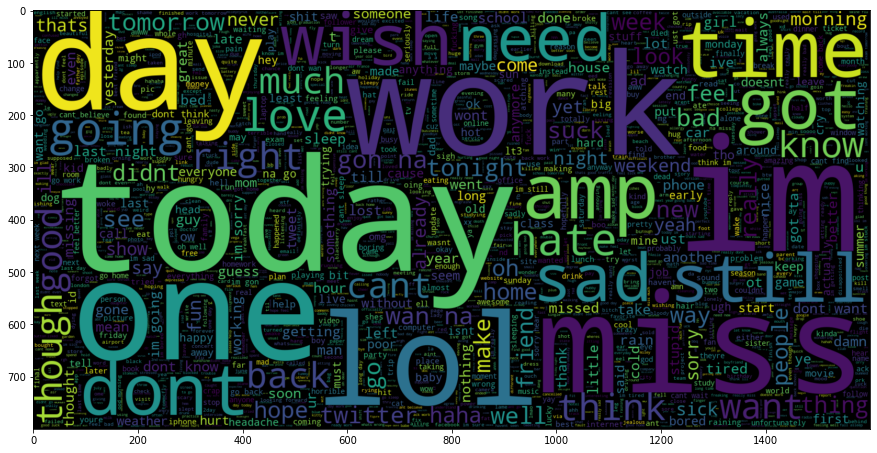

In [24]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

### Word-Cloud for Positive tweets.

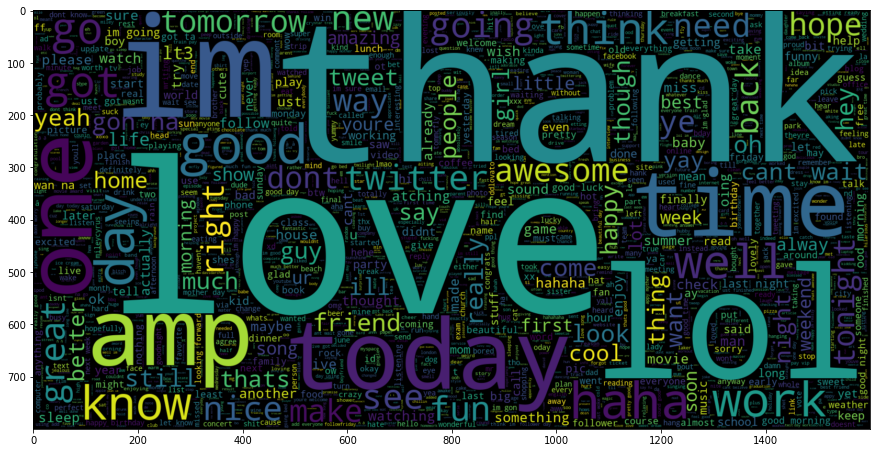

In [25]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

## Vectorization and Splitting the data <a id="6"></a>
Storing input variable-processes_tweets to X and output variable-polarity to y

In [26]:
X = data['processed_tweets'].values
y = data['polarity'].values


In [27]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


## Convert text to word frequency vectors
### TF-IDF
 This is an acronym than stands for **Term Frequency – Inverse Document** Frequency which are the components of the resulting scores assigned to each word.

* Term Frequency: This summarizes how often a given word appears within a document.
* Inverse Document Frequency: This downscales words that appear a lot across documents.

In [28]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.
No. of feature_words:  170635


In [29]:
print(X.shape)
print(y.shape)

(200000, 170635)
(200000,)


## Split train and test

The Preprocessed Data is divided into 2 sets of data:

* Training Data: The dataset upon which the model would be trained on. Contains 80% data.
* Test Data: The dataset upon which the model would be tested against. Contains 20% data.




In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [31]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 170635)
y_train (160000,)

X_test (40000, 170635)
y_test (40000,)


# Model Building <a id="7"></a>

### Model evaluating function

In [32]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Logistic Regression <a id="8"></a>

Accuracy of model on training data : 83.38875
Accuracy of model on testing data : 76.9 

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     19958
           1       0.76      0.80      0.78     20042

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



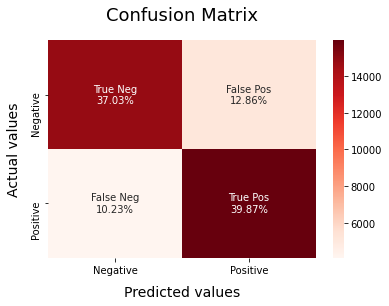

In [33]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

### Linear SVM <a id="9"></a>

Accuracy of model on training data : 93.00625
Accuracy of model on testing data : 76.0775 

              precision    recall  f1-score   support

           0       0.77      0.74      0.76     19958
           1       0.75      0.78      0.77     20042

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



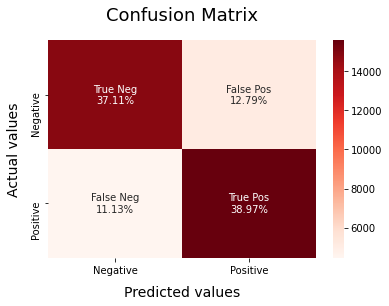

In [34]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

### Random Forest <a id="10"></a>

Accuracy of model on training data : 75.483125
Accuracy of model on testing data : 70.44500000000001 

              precision    recall  f1-score   support

           0       0.72      0.66      0.69     19958
           1       0.69      0.74      0.72     20042

    accuracy                           0.70     40000
   macro avg       0.71      0.70      0.70     40000
weighted avg       0.71      0.70      0.70     40000



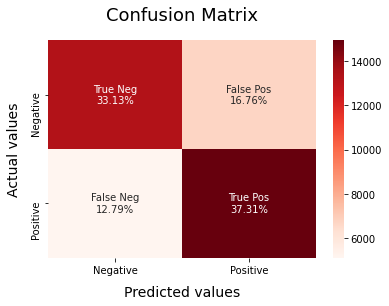

In [35]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

### Naive Bayes <a id="11"></a>

Accuracy of model on training data : 86.78812500000001
Accuracy of model on testing data : 76.05499999999999 

              precision    recall  f1-score   support

           0       0.75      0.78      0.77     19958
           1       0.77      0.74      0.76     20042

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



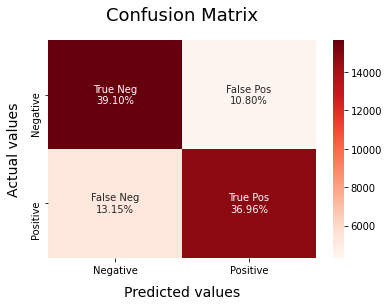

In [36]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

# RNN <a id="12"></a>

In [37]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re

In [38]:
import keras
keras.__version__

'2.4.3'

In [39]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   19  160 1516]
 [   0    0    0 ...  380  173  444]
 [   0    0    0 ...    0  133  455]
 ...
 [   0    0    0 ...  523 2277  140]
 [   0    0    0 ... 3994   33  540]
 [   0    0    0 ...  220   13   68]]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)

In [41]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])


Epoch 1/10
5000/5000 [==============================] - 86s 16ms/step - loss: 0.5415 - accuracy: 0.7158 - val_loss: 0.4831 - val_accuracy: 0.7646

Epoch 00001: val_accuracy improved from -inf to 0.76458, saving model to rnn_model.hdf5
Epoch 2/10
5000/5000 [==============================] - 82s 16ms/step - loss: 0.4667 - accuracy: 0.7756 - val_loss: 0.4804 - val_accuracy: 0.7663

Epoch 00002: val_accuracy improved from 0.76458 to 0.76635, saving model to rnn_model.hdf5
Epoch 3/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.4515 - accuracy: 0.7827 - val_loss: 0.4766 - val_accuracy: 0.7693

Epoch 00003: val_accuracy improved from 0.76635 to 0.76928, saving model to rnn_model.hdf5
Epoch 4/10
5000/5000 [==============================] - 83s 17ms/step - loss: 0.4358 - accuracy: 0.7922 - val_loss: 0.4822 - val_accuracy: 0.7684

Epoch 00004: val_accuracy did not improve from 0.76928
Epoch 5/10
5000/5000 [==============================] - 83s 17ms/step - loss: 0.4236 - 

In [42]:
sequence = tokenizer.texts_to_sequences(['this data science article is the worst ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')
# print(pred)

Negative


In [43]:
model = keras.models.load_model('rnn_model.hdf5')
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

Positive


In [44]:
sequence = tokenizer.texts_to_sequences(['I had a bad day at work.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

Negative


# Model Saving, Loading and Prediction <a id="13"></a>

In [45]:
import pickle

file = open('vectoriser.pickle','wb')
pickle.dump(vector, file)
file.close()

file = open('logisticRegression.pickle','wb')
pickle.dump(lg, file)
file.close()

file = open('SVM.pickle','wb')
pickle.dump(svm, file)
file.close()

file = open('RandomForest.pickle','wb')
pickle.dump(rf, file)
file.close()

file = open('NaivesBayes.pickle','wb')
pickle.dump(nb, file)
file.close()

### Predict using saved model

In [46]:
def load_models():
    # Load the vectoriser.
    file = open('vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('logisticRegression.pickle', 'rb')
    lg = pickle.load(file)
    file.close()
    return vectoriser, lg

In [47]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    processes_text=[process_tweets(sen) for sen in text]
    textdata = vectoriser.transform(processes_text)
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [48]:
if __name__=="__main__":
    # Loading the models.
    vectoriser, lg = load_models()
    
    # Text to classify should be in a list.
    text = ["I love machine learning",
            "Work is too hectic.",
            "Mr.Sharama, I feel so good"]
    
    df = predict(vectoriser, lg, text)
    print(df.head())


                         text sentiment
0     I love machine learning  Positive
1         Work is too hectic.  Negative
2  Mr.Sharama, I feel so good  Positive
